In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [2]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [3]:
# We filter the country, the variable to predict and the dates

country = 'Spain'
variable = 'new_cases_'
col = variable + country
datecol = 'date'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

In [4]:
# We read the endogenous data (coronavirus data) (for now, from a local file)

covid_ctry_varR = pd.read_csv('./data/endogenous.csv', parse_dates=[datecol], index_col=[datecol], usecols=[datecol, col])

In [5]:
# We now read the exogenous data (for now, from a local file):

exogenous = pd.read_csv('./data/exogenous.csv', parse_dates=[datecol], index_col=[datecol])

# We now need to filter the country:
exogenous_ctryR = exogenous.loc[:, exogenous.columns.str.contains(country)]

In [6]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(245, 1) (245, 14)


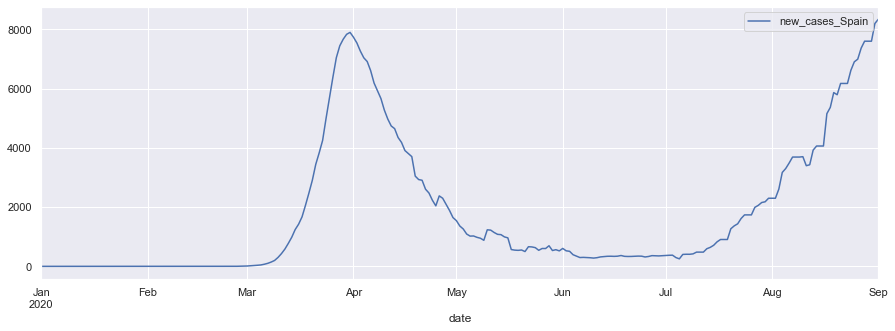

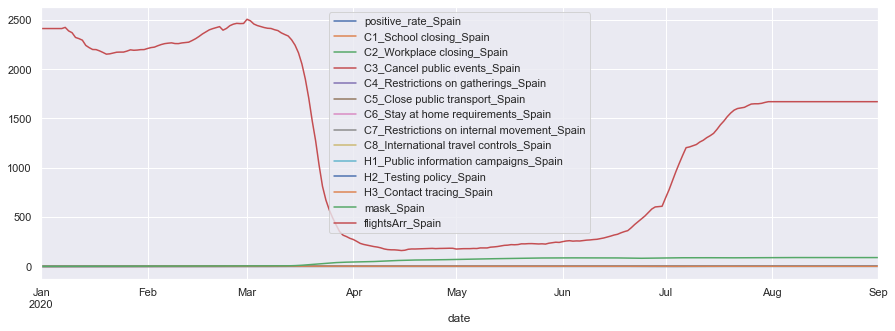

In [7]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [8]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [9]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
y = scaled_output.resample('1D').sum()

(245,) (245, 14)


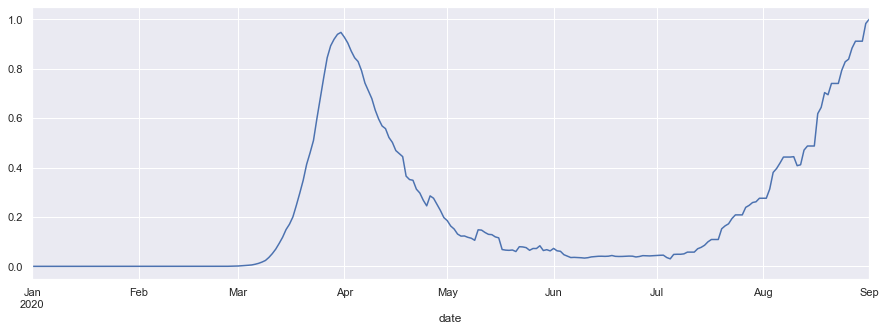

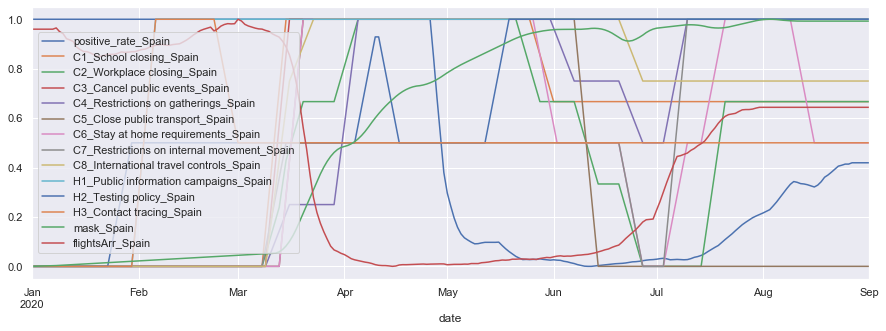

In [10]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [11]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [12]:
train_size, test_size

(208, 37)

# Stationarity: estimate differencing term (d)

In [13]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


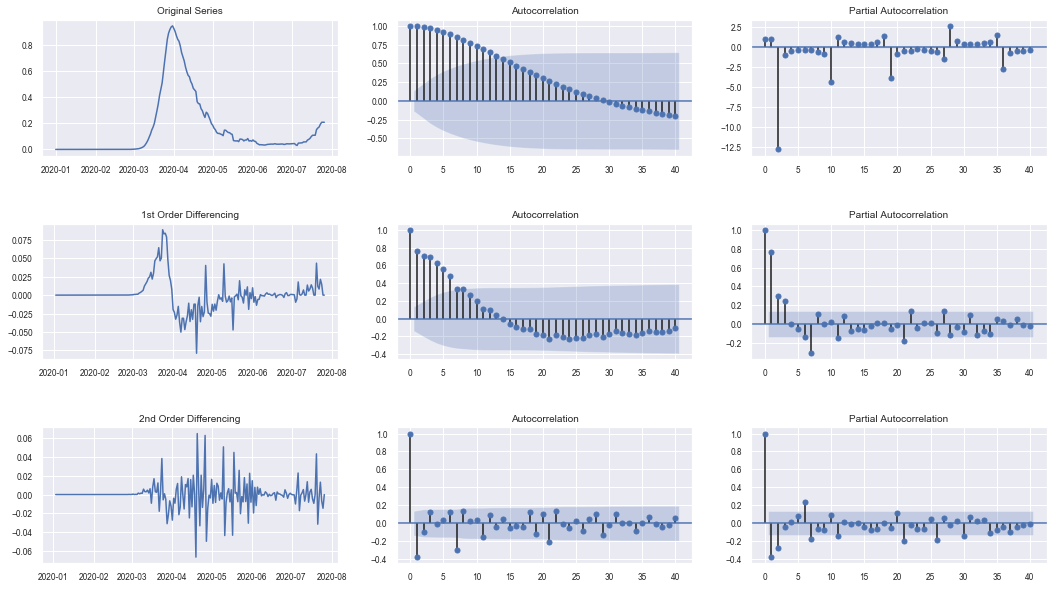

In [14]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

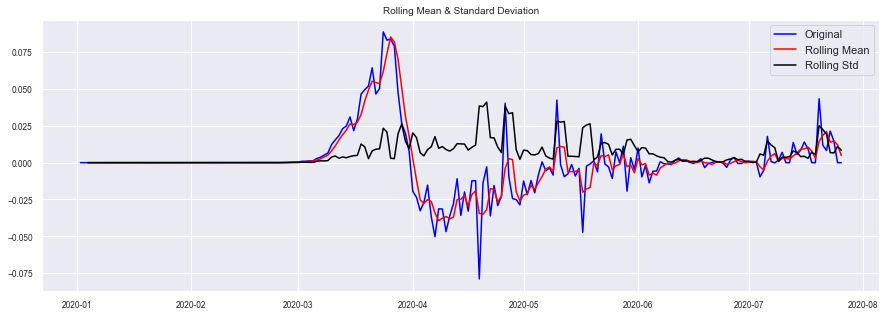

Result of Dicky-Fuller Test


Test Statistic           -3.392821
p-value                   0.011206
#Lags Used                7.000000
#Observations Used      199.000000
Critical Value (1%)      -3.463645
Critical Value (5%)      -2.876176
Critical Value (10%)     -2.574572
dtype: float64

In [15]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [16]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(0, 2, 3)",-1205.664338
1,"(1, 1, 3)",-1199.969280
2,"(1, 1, 3)",-1199.969280
3,"(0, 2, 1)",-1197.105553


# Perform cross-validation on top 2 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [17]:
# Extract top 3 models from previous step (first 3 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])
model3 = ARIMA(order=result_table.iloc[2,0])

In [18]:
best_order = cross_val(y_train, X_train, model1, model2, model3)

Model 1 CV scores: ['0.2228', '0.4825', '0.3277', '506784951589.7030', '3668842060934.7993', '0.3241', '0.0691', '0.0744', '0.1883', '0.0198']
Model 2 CV scores: ['0.0887', '0.2790', '0.0333', '0.0565', '0.0335', '0.0142', '0.0083', '0.0460', '0.6355', '0.0879']
Model 3 CV scores: ['0.0887', '0.2790', '0.0333', '0.0565', '0.0335', '0.0142', '0.0083', '0.0460', '0.6355', '0.0879']
Lowest average MAE: 0.12827943030581485 (model2)
Best model order: (1, 1, 3)


                               SARIMAX Results                                
Dep. Variable:        new_cases_Spain   No. Observations:                  208
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 620.832
Date:                Wed, 02 Sep 2020   AIC                          -1203.664
Time:                        12:58:57   BIC                          -1140.342
Sample:                    01-01-2020   HQIC                         -1178.057
                         - 07-26-2020                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1703      0.057      2.999      0.003       0.059       0.282
C1_School closing_Spain            

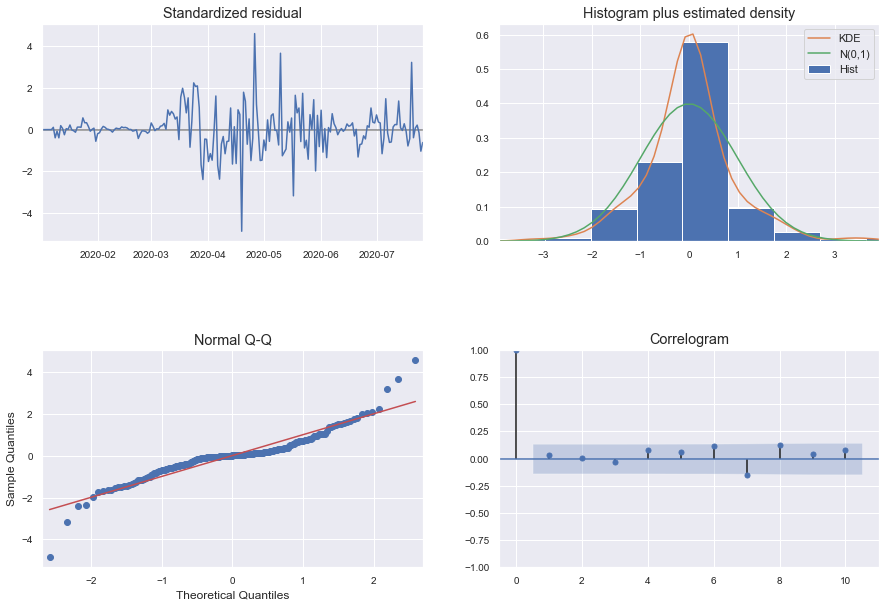

In [85]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=best_order, exog=X_train)
results = best_model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [86]:
train_size, test_size, X_test.shape

(208, 37, (37, 14))

Test MAE: 0.345


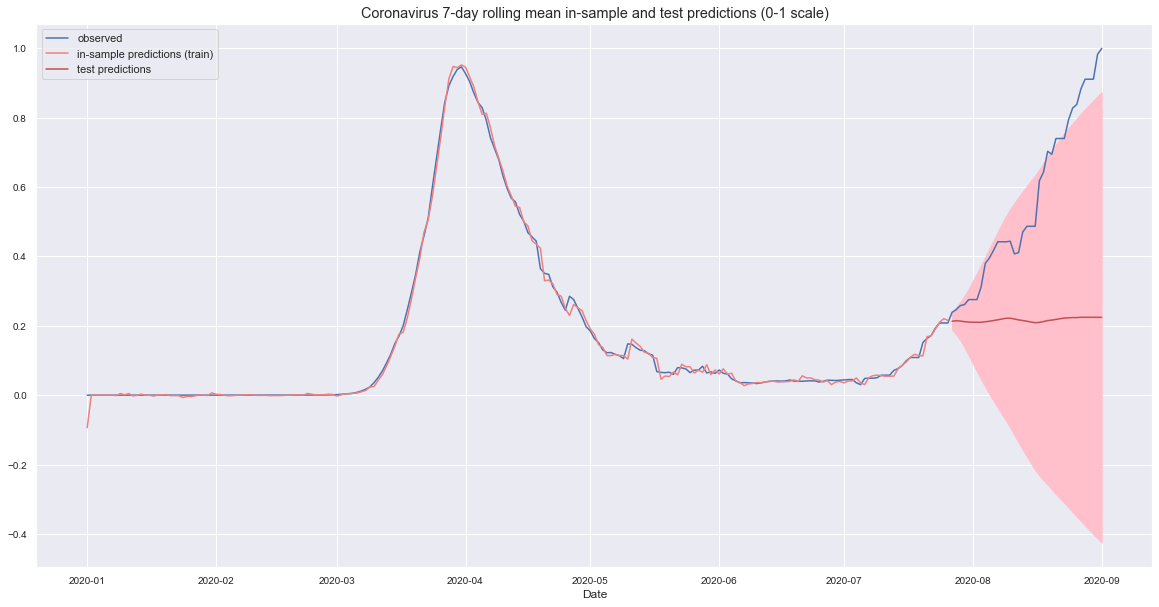

In [87]:
in_predictions, mean_forecast = in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

# Scale data back to original values and plot

In [88]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.columns[0])

In [89]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.columns[0])

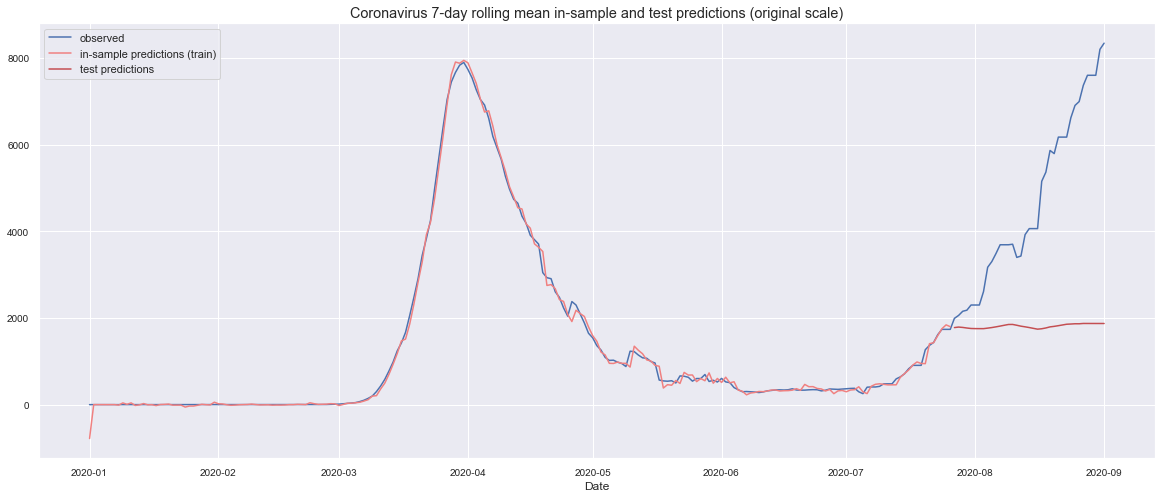

In [90]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [91]:
print("Test MAE (original scale): %.3f" % np.sqrt(mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)))

Test MAE (original scale): 53.659


# Save model so we can then update with future values

In [92]:
# Set model name
filename = './models/' + country + 'SARIMAXmodel.pkl'

# Pickle it
joblib.dump(results, filename)

['./models/SpainSARIMAXmodel.pkl']

In [93]:
# Load the model back in
loaded_model = joblib.load(filename)

In [94]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        new_cases_Spain   No. Observations:                  208
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 620.832
Date:                Wed, 02 Sep 2020   AIC                          -1203.664
Time:                        12:58:59   BIC                          -1140.342
Sample:                    01-01-2020   HQIC                         -1178.057
                         - 07-26-2020                                         
Covariance Type:                  opg                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1703      0.057      2.999      0.003       0.059       0.282
C1_School closing_Spain                       -0.0511      0.118     -0.432      0.666      -0.283       0.181
C2_Workplace closing_Spain                     0.0372      0.094      0.396      0.692      -0.147       0.221
C3_Cancel public events_Spain                  0.4903      0.152      3.221      0.001       0.192       0.789
C4_Restrictions on gatherings_Spain           -0.1471      0.081     -1.823      0.068      -0.305       0.011
C5_Close public transport_Spain               -0.0444      0.119     -0.373      0.709      -0.278       0.189
C6_Stay at home requirements_Spain             0.0176      0.097      0.181      0.856      -0.172       0.207
C7_Restrictions on internal movement_Spain     0.1057      0.082      1.290      0.197      -0.055       0.266
C8_International travel controls_Spain        -0.6535      0.195     -3.358      0.001      -1.035      -0.272
H1_Public information campaigns_Spain          0.0879      0.657      0.134      0.894      -1.200       1.376
H2_Testing policy_Spain                       -0.0995      0.054     -1.832      0.067      -0.206       0.007
H3_Contact tracing_Spain                      -0.0815      0.641     -0.127      0.899      -1.337       1.174
mask_Spain                                     0.2049      0.371      0.553      0.580      -0.521       0.931
flightsArr_Spain                              -0.2751      0.154     -1.789      0.074      -0.576       0.026
ar.L1                                          0.8606      0.040     21.446      0.000       0.782       0.939
ma.L1                                         -0.5111      0.081     -6.279      0.000      -0.671      -0.352
ma.L2                                         -0.0274      0.077     -0.354      0.723      -0.179       0.124
ma.L3                                          0.2763      0.064      4.296      0.000       0.150       0.402
sigma2                                         0.0001   1.17e-05     12.401      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       66.83   Jarque-Bera (JB):               242.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.85   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Update model with test observations, to get it ready for future forecasts

In [95]:
# Update model with test sample and re-fit parameters:
res_updated = results.append(y_test, exog=X_test, refit=True)

                               SARIMAX Results                                
Dep. Variable:        new_cases_Spain   No. Observations:                  245
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 649.556
Date:                Wed, 02 Sep 2020   AIC                          -1261.112
Time:                        12:59:00   BIC                          -1194.666
Sample:                    01-01-2020   HQIC                         -1234.351
                         - 09-01-2020                                         
Covariance Type:                  opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
positive_rate_Spain                            0.1524      0.087      1.758      0.079      -0.017       0.322
C1_School closing_Spain            

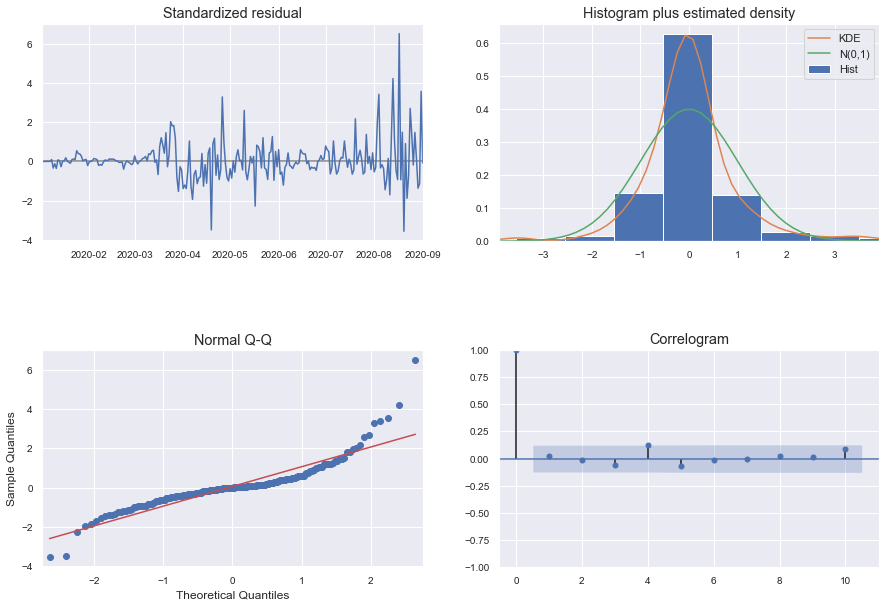

In [96]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

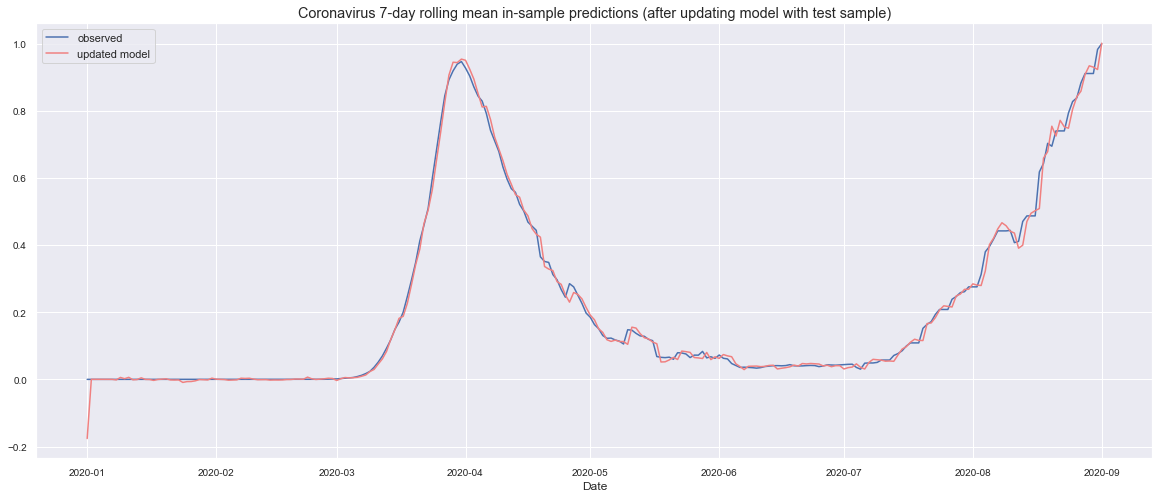

In [97]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [98]:
# Save model again, after updating it with test sample:

joblib.dump(res_updated, filename)

['./models/SpainSARIMAXmodel.pkl']

# Perform forecast

In [99]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdate, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

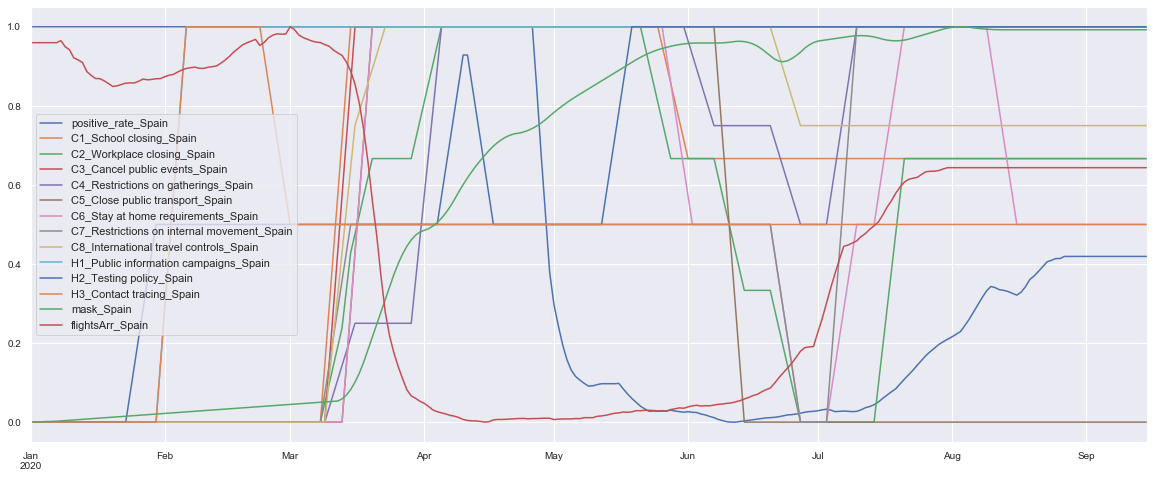

In [100]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[1.01509368 1.03744334 1.05653599 1.07304687 1.0873251  1.09967257
 1.11035039 1.11958432 1.1275696  1.13447509 1.1404468  1.14561099
 1.15007687 1.15393885]


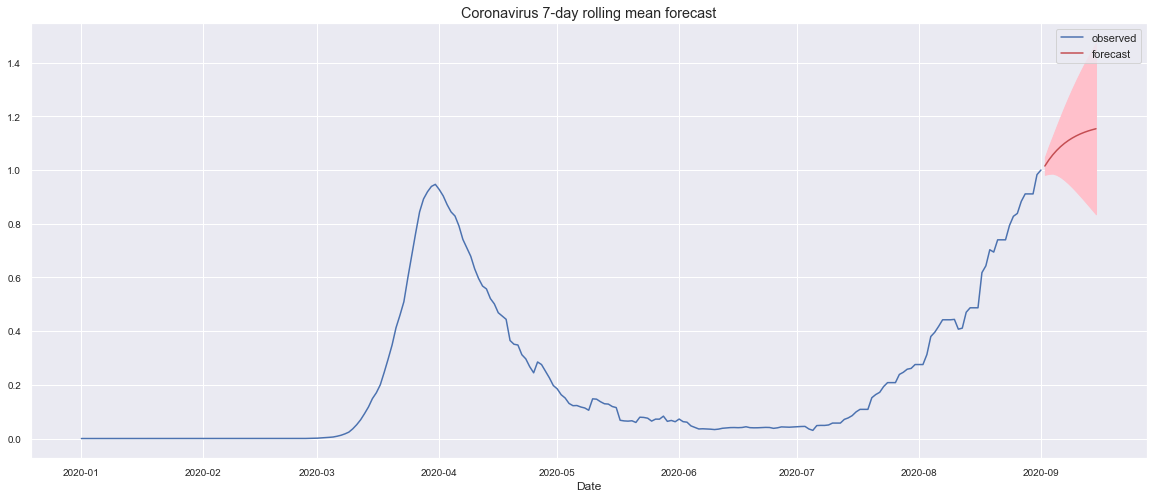

In [101]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + y.name]
upper_limits = confidence_intervals.loc[:,'upper ' + y.name]

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [102]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

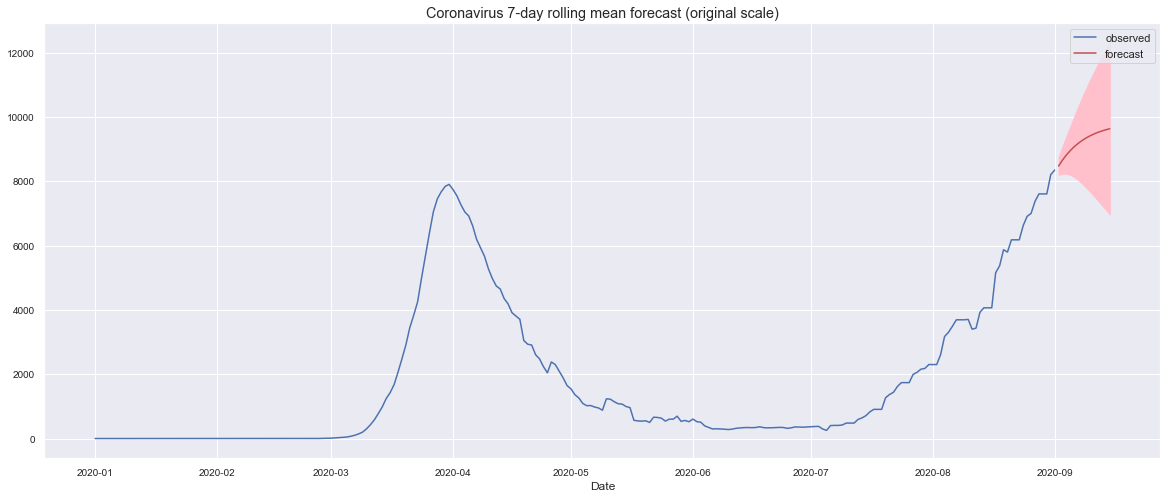

In [103]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.legend()
plt.show()

In [104]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['8471.7', '8658.2', '8817.5', '8955.3', '9074.5', '9177.6', '9266.7', '9343.7', '9410.4', '9468.0', '9517.8', '9560.9', '9598.2', '9630.4']


In [105]:
sm.__version__

'0.11.1'

In [106]:
import pmdarima as pm
pm.__version__

'1.6.1'